## Subsection 1.1 - Calculating the trajectory and plotting Poincaré map

In [121]:
import numpy as np
from scipy.integrate import solve_ivp  
import matplotlib.pyplot as plt
from matplotlib import rc

# use latex for plotting
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)

# Define the system of ODEs
def system(t, x):
    x1, x2, x3 = x
    dx1dt = 4 * x2**2 - 2 * x2 * x3 + 2.1 * x3
    dx2dt = x3 - 2 * x2
    dx3dt = x2 - x1
    return [dx1dt, dx2dt, dx3dt]

# Define the event function: x3 = 0 and x1 > 0
def return_event(t, x):
    return x[2]  # x3 = 0

return_event.terminal = False  # Stop the integration at the event
return_event.direction = -1     # Look for crossings from x3 > 0 to x3 < 0

def integrate_and_find_return(x1_0, x2_0, t_span):
    x0 = [x1_0, x2_0, -0.000001]
    # stop solve_ivp after max_num_events events
    sol = solve_ivp(system, t_span, x0, events=return_event, dense_output=True, max_step=0.01)
    if sol.t_events[0].size == 0:
        raise RuntimeError("No return to x3 = 0 detected in time span.")
    
    t_r = sol.t_events[0] # times when x3 crosses zero
    x_r = sol.sol(t_r) # solution at these times
    return x_r[0], x_r[1]

# Example usage
x1_0 = 20.
x2_0 = 2.17
x1_tr_original_order, x2_tr_original_order = integrate_and_find_return(x1_0, x2_0, t_span=(0, 10000))
points = zip(x1_tr_original_order, x2_tr_original_order)
# sorting x1_tr and x2_tr in order to differentiate the two regions of the trajectory in the x1 axis
sorted_points = sorted(points, key=lambda p: p[0])
x1_tr, x2_tr = zip(*sorted_points)
# extract x1_tr and x2_tr as numpy arrays
x1_tr = np.array(x1_tr)
x2_tr = np.array(x2_tr)

# Calculate the range of the two regions of the trajectory
# create a shifted-left x1_tr array to find the value where the trajectory is separated
separation_index = np.argmax(x1_tr[1:] - x1_tr[:-1])
x_B_l = x1_tr[0]
x_B_r = x1_tr[separation_index - 1]

x_A_l = x1_tr[separation_index]
x_A_r = x1_tr[-1]


# Deviding the trajectory into two regions based on x1
# extract the indexes of the points in each region
# Region A: x_A_l <= x1_tr <= x_A_r
# Region B: x_B_l <= x1_tr <= x_B_r
A_indexes = np.where((x_A_l < x1_tr) & (x1_tr <= x_A_r))
x1_A = x1_tr[A_indexes]
x2_A = x2_tr[A_indexes]

B_indexes = np.where((x_B_l <= x1_tr) & (x1_tr < x_B_r))
x1_B = x1_tr[B_indexes]
x2_B = x2_tr[B_indexes]

# For writing this function, I was assisted by GitHub Copilot.
def quadratic_fit_function(x_1, x_2):
    coeffs = np.polyfit(x_1, x_2, 2)
    return np.poly1d(coeffs)

# Fit a quadratic function to the points where x1 > 15
fit_func_A = quadratic_fit_function(x1_A, x2_A)
x1_A_fit = np.linspace(np.min(x1_A), np.max(x1_A), 100)
x2_A_fit = fit_func_A(x1_A_fit)

fit_func_B = quadratic_fit_function(x1_B, x2_B)
x1_B_fit = np.linspace(np.min(x1_B), np.max(x1_B), 100)
x2_B_fit = fit_func_B(x1_B_fit)

C:\Users\TLP-001\AppData\Local\Temp\ipykernel_86964\1452727835.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1_tr_original_order[:cut], x2_tr_original_order[:cut], c=color_values[:cut], cmap='viridis', label='Trajectory Points')


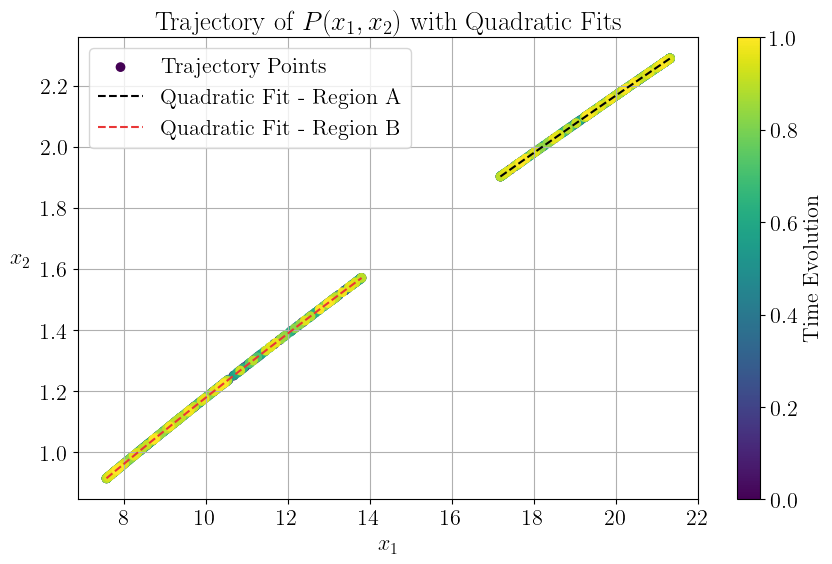

In [206]:

# Plotting the trajectory and the quadratic fit
plt.figure(figsize=(10, 6))
cut =1000
colors = plt.cm.viridis(np.linspace(0, 1, cut))
color_values = [colors[i] for i in range(cut)]
plt.scatter(x1_tr_original_order[:cut], x2_tr_original_order[:cut], c=color_values[:cut], cmap='viridis', label='Trajectory Points')
plt.colorbar(label='Time Evolution')
plt.plot(x1_A_fit, x2_A_fit, color="#000000", linestyle="--", label='Quadratic Fit - Region A')
plt.plot(x1_B_fit, x2_B_fit, color="#E93636FF", linestyle="--", label='Quadratic Fit - Region B')
plt.xlabel('$x_1$')
# make ylabel text vertical with space between the text and the axis
plt.ylabel('$x_2$', rotation=0, labelpad=15)
plt.title('Trajectory of $P(x_1,x_2)$ with Quadratic Fits')
plt.legend()
plt.grid()

## Subsection 1.2 - Defining 1-DOF reduced Poincaré map

In [208]:
# used auto-complete of GitHub Copilot to write this function.
def get_x2_fit(x1, tol=1e-2):
    if x_A_l - tol <= x1 <= x_A_r + tol:
        return fit_func_A(x1)
    elif x_B_l - tol <= x1 <= x_B_r + tol:
        return fit_func_B(x1)
    
    # The map action is not defined for x1 outside the regions A and B

def p(x1):
    x2 = get_x2_fit(x1)
    return_event.terminal = True  # Stop the integration at the event (one action)
    # make sure that the inegration is stopped at the first event
    new_x1 = integrate_and_find_return(x1, x2, t_span=(0,1000))[0][0]
    return new_x1


# Plot the 1-DOF reduced Poincaré map
# Use colors to demonstrate the time evolution of the trajectory
# use original points array from the trajectory to assign colors for the points of the trajectory,
# and then plot the points on the Poincaré map with the same colors.

# use poincare_map to get the corresponding x2 values for the Poincaré map
# and plot the points with the same colors
x1_values = x1_tr_original_order
p2_values = [p(x1) for x1 in x1_values]


C:\Users\TLP-001\AppData\Local\Temp\ipykernel_86964\2209040104.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1_values, p2_values, cmap='viridis', label='Poincaré Map Points')


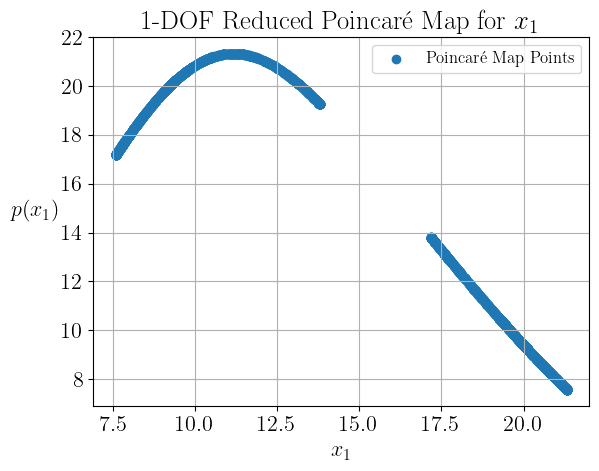

In [209]:
# scatter plot of the Poincaré map, where each point is colored according to its time evolution
plt.scatter(x1_values, p2_values, cmap='viridis', label='Poincaré Map Points')
plt.title('1-DOF Reduced Poincaré Map for $x_1$')
plt.xlabel('$x_1$')
# make ylabel text vertical with space between the text and the axis
plt.ylabel('$p(x_1)$', rotation=0, labelpad=20)
plt.legend(fontsize=12)
plt.grid()
plt.show()


## Subsection 1.3 - Defining 1-DOF reduced Poincaré map for $P^2$

In [ ]:
def p_2(x1):
    x2 = get_x2_fit(x1)
    return_event.terminal = 2  # Stop the integration at the event (one action)
    # make sure that the inegration is stopped at the first event
    new_x1 = integrate_and_find_return(x1, x2, t_span=(0,1000))[0][1]
    return new_x1

x1_values = x1_tr_original_order[(x_A_l < x1_tr_original_order) & (x1_tr_original_order <= x_A_r)]
p2_values = [p_2(x1) for x1 in x1_values]

# Applying a quadratic fit to the Poincaré map
p2_quad_fit = quadratic_fit_function(x1_values, p2_values)
x1_fit = np.linspace(np.min(x1_values), np.max(x1_values), 1000)
q2 = p2_quad_fit(x1_fit)



C:\Users\TLP-001\AppData\Local\Temp\ipykernel_86964\864817421.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1_values, p2_values, cmap='viridis', label='Poincaré Map Points')


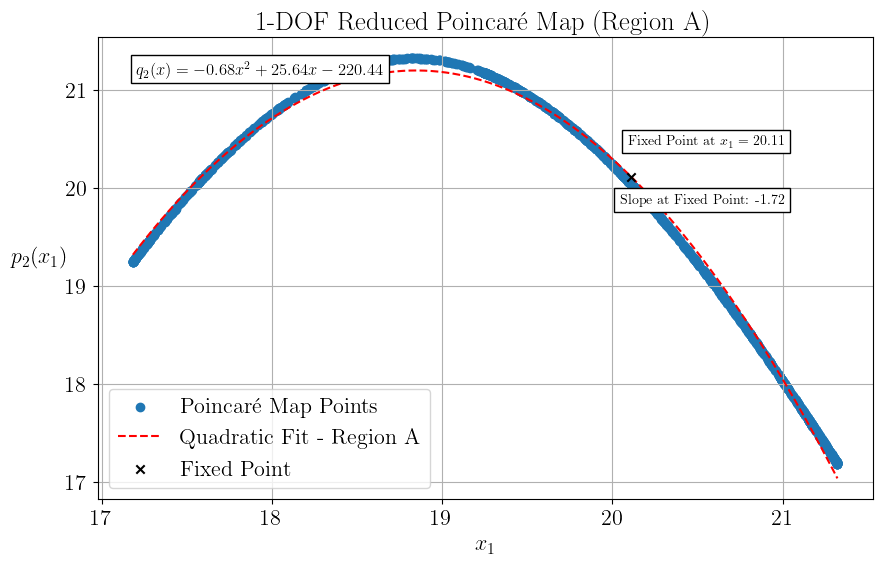

In [196]:
# scatter plot of the Poincaré map, where each point is colored according to its time evolution
plt.figure(figsize=(10, 6))
plt.scatter(x1_values, p2_values, cmap='viridis', label='Poincaré Map Points')

plt.plot(x1_fit, q2, 'r--', label='Quadratic Fit - Region A')

# show the equation of the quadratic fit on the plot
equation = f'$q_2(x) = {p2_quad_fit.coefficients[0]:.2f} x^2 + {p2_quad_fit.coefficients[1]:.2f} x - {np.abs(p2_quad_fit.coefficients[2]):.2f}$'
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black'))
# q2 fixed point
q2_fixed_point = np.roots(np.array([p2_quad_fit.coefficients[0], p2_quad_fit.coefficients[1], p2_quad_fit.coefficients[2]]) - np.array([0, 1, 0]))[0]
# show the fixed point on the plot
plt.scatter(q2_fixed_point, p2_quad_fit(q2_fixed_point), color='black', marker='x', label='Fixed Point', zorder=5)
plt.text(q2_fixed_point + 0.9, p2_quad_fit(q2_fixed_point) + 0.3, f'Fixed Point at $x_1 = {q2_fixed_point:.2f}$',
         fontsize=10, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=1))

# calculate the slope of the quadratic fit at the fixed point
slope_at_fixed_point = 2 * p2_quad_fit.coefficients[0] * q2_fixed_point + p2_quad_fit.coefficients[1]
# show the slope on the plot
plt.text(q2_fixed_point + 0.9, p2_quad_fit(q2_fixed_point) - 0.3, f'Slope at Fixed Point: {slope_at_fixed_point:.2f}',
         fontsize=10, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=1))

plt.title('1-DOF Reduced Poincaré Map (Region A)')
plt.xlabel('$x_1$')
plt.ylabel('$p_2(x_1)$', rotation=0, labelpad=20)
plt.legend()
plt.grid()
plt.show()




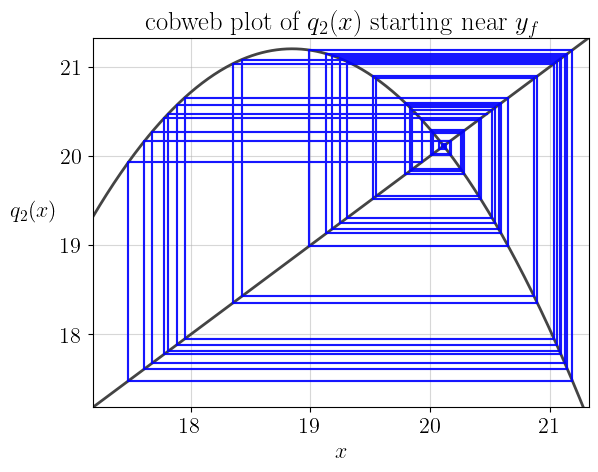

In [150]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt


def plot_cobweb(x0, nmax=100):
    x = np.linspace(np.min(x1_values), np.max(x1_values), 500)
    # Plot y = f(x) and y = x
    plt.plot(x, p2_quad_fit(x), c='#444444', lw=2)
    plt.plot(x, x, c="#444444", lw=2)

    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,nmax+1,2))
    px[0], py[0] = x0, p2_quad_fit(x0)
    for n in range(1, nmax, 2):
        px[n] = px[n-1]
        py[n] = p2_quad_fit(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]

    # Plot the path traced out by the iteration.
    plt.plot(px, py, c='b', alpha=0.7)

    # Annotate and tidy the plot.
    plt.grid(which='minor', alpha=0.5)
    plt.grid(which='major', alpha=0.5)
    plt.xlim(np.min(x1_values), np.max(x1_values))
    plt.ylim(np.min(p2_values), np.max(p2_values))
    plt.xlabel('$x$')
    plt.ylabel('$q_2(x)$', rotation=0, labelpad=20)
    plt.title('cobweb plot of $q_2(x)$ starting near $y_f$')

x_0 = 20.11
plot_cobweb(x_0)


## Subsection 1.4 - Fixed Point

Distance to fixed point in Poincaré map: 0.0787
Distance to fixed point in 3D system: 0.0000000000000000


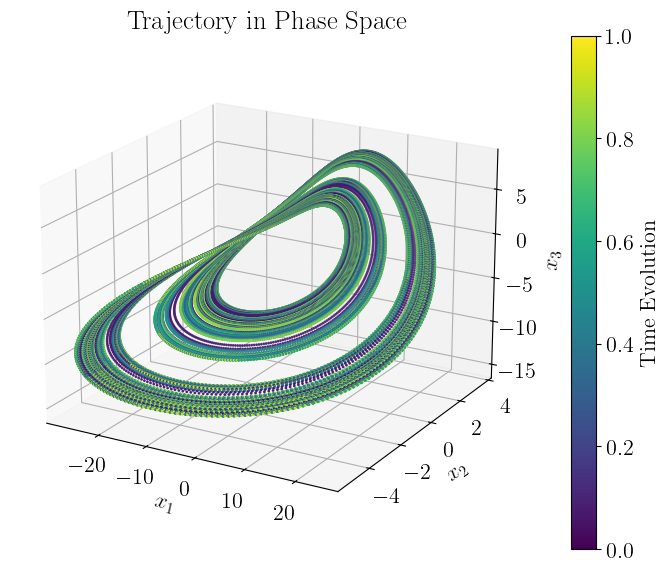

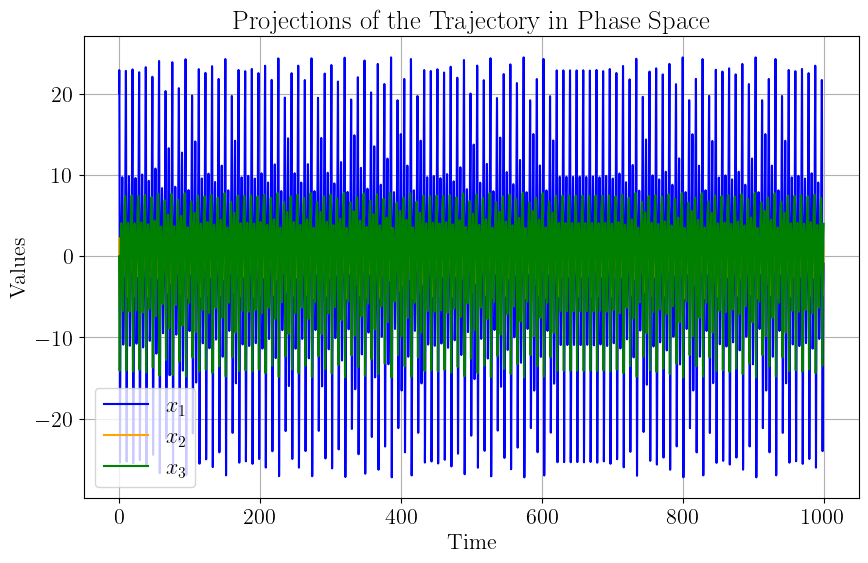

In [201]:
y_f = np.roots(np.array([p2_quad_fit.coefficients[0], p2_quad_fit.coefficients[1], p2_quad_fit.coefficients[2]]) - np.array([0, 1, 0]))[0]

# Example usage
x1_0 = y_f
x2_0 = get_x2_fit(y_f)
return_event.terminal = 3
x1_tr, x2_tr = integrate_and_find_return(x1_0, x2_0, t_span=(0, 1000))

# calculate the distance between (x1_tr[-1], x2_tr[-1]) and the fixed point (y_f, get_x2_fit(y_f))
distance_to_fixed_point = np.sqrt((x1_tr[1] - y_f)**2 + (x2_tr[1] - get_x2_fit(y_f))**2)
print(f"Distance to fixed point in Poincaré map: {distance_to_fixed_point:.4f}")

def integrate_flow(x0, t_span):
    sol = solve_ivp(system, t_span, x0, dense_output=True, max_step=0.01)
    t = sol.t  # time points
    x = sol.y  # solution at these time points
    x1, x2, x3 = x
    return t, x1, x2, x3

# Plot the trajectory in the phase space
# Notice that the trajectory is 4D, so we plot (x1, x2, x3) in 3D and 
# give each point a color according to the time evolution.
t, x1_tr, x2_tr, x3_tr = integrate_flow([x1_0, x2_0, 0], t_span=(0, 1000))
points = zip(x1_tr, x2_tr, x3_tr)

# calculate the distance between (x1_tr, x2_tr, x3_tr) and the fixed point (y_f, get_x2_fit(y_f), 0)
# find the minimum distance to the fixed point, not necessarily the last point
# this is because the trajectory might not converge to the fixed point in the time span
distance_to_fixed_point = np.sqrt((x1_tr - y_f)**2 + (x2_tr - get_x2_fit(y_f))**2 + x3_tr**2)
min_distance_index = np.argmin(distance_to_fixed_point)
x1_tr_closest = x1_tr[min_distance_index]
x2_tr_closest = x2_tr[min_distance_index]
x3_tr_closest = x3_tr[min_distance_index]
# calculate the distance between (x1_tr[-1], x2_tr[-1], x3_tr[-1]) and the fixed point (y_f, get_x2_fit(y_f), 0)
distance_to_fixed_point = np.sqrt((x1_tr_closest - y_f)**2 + (x2_tr_closest - get_x2_fit(y_f))**2 + x3_tr_closest**2)
print(f"Distance to fixed point in 3D system: {distance_to_fixed_point:.16f}")

color_values = plt.cm.viridis(np.linspace(0, 1, len(t)))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# decrease the size of the points to avoid cluttering
ax.scatter(x1_tr, x2_tr, x3_tr, c=color_values, s=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$', rotation=1, labelpad=5)
ax.set_title('Trajectory in Phase Space')

# add a color bar to indicate the time evolution
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
cbar.set_label('Time Evolution')
ax.view_init(elev=20, azim=-60)  # Adjust the view angle
plt.tight_layout()
plt.show()

# plot projections of the trajectory in the phase space in a single plot
plt.figure(figsize=(10, 6))
plt.plot(t, x1_tr, label='$x_1$', color='blue')
plt.plot(t, x2_tr, label='$x_2$', color='orange')
plt.plot(t, x3_tr, label='$x_3$', color='green')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Projections of the Trajectory in Phase Space')
plt.legend()
plt.grid()
plt.show()





## Subsection 1.4 - Determine Quasi-Periodic Trajectory

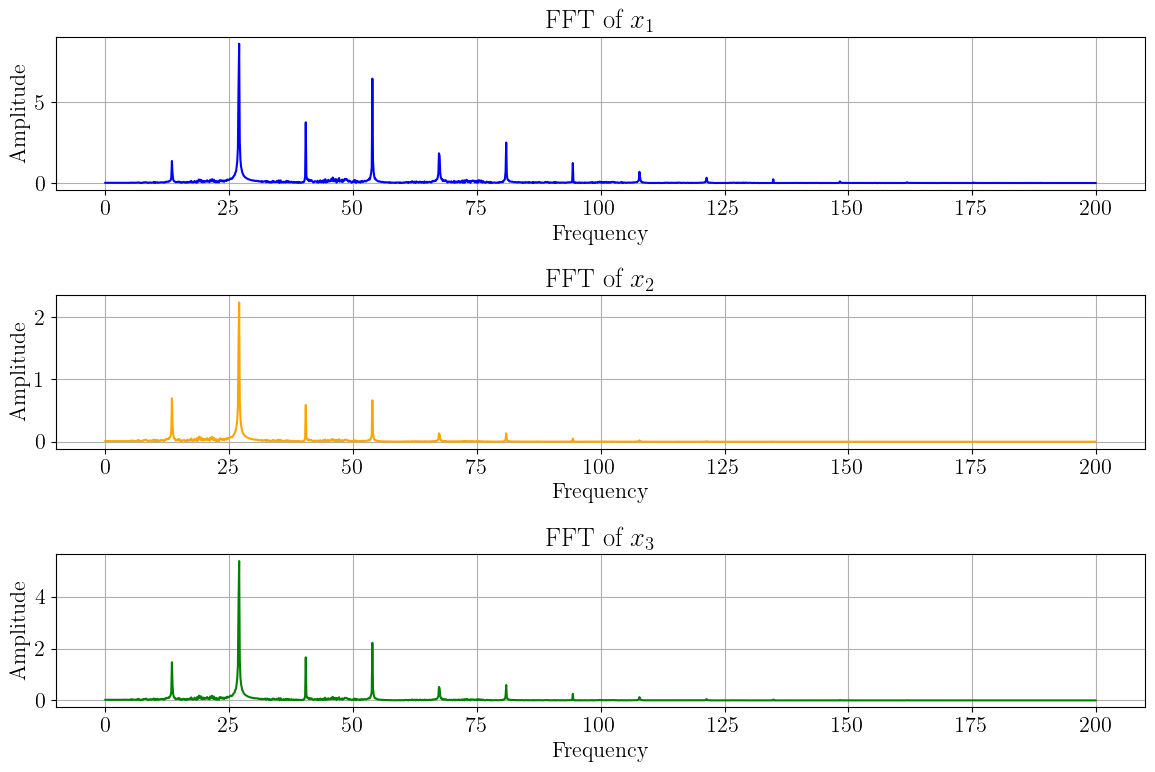

In [202]:
# Compute the FFT of the trajectory in the all directions
from scipy.fft import fft, fftfreq
def compute_fft(x, t):
    N = len(x)
    T = t[1] - t[0]  # Sampling interval
    yf = fft(x)
    xf = fftfreq(N, T)[:N//2]
    # cut xf until 50 Hz
    xf = xf[xf <= 200]
    yf = yf[:N//2]
    # cut yf to match xf
    yf = yf[:len(xf)]
    # Normalize the amplitude
    yf = 2.0/N * np.abs(yf)
    return xf, yf

xf1, yf1 = compute_fft(x1_tr, t)
xf2, yf2 = compute_fft(x2_tr, t)
xf3, yf3 = compute_fft(x3_tr, t)

# Plot the FFT results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(xf1, yf1, color='blue')
plt.title('FFT of $x_1$')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(xf2, yf2, color='orange')
plt.title('FFT of $x_2$')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(xf3, yf3, color='green')
plt.title('FFT of $x_3$')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

## Subsection 1.7 - Finding Fixed Points of $q_2^4(x)$

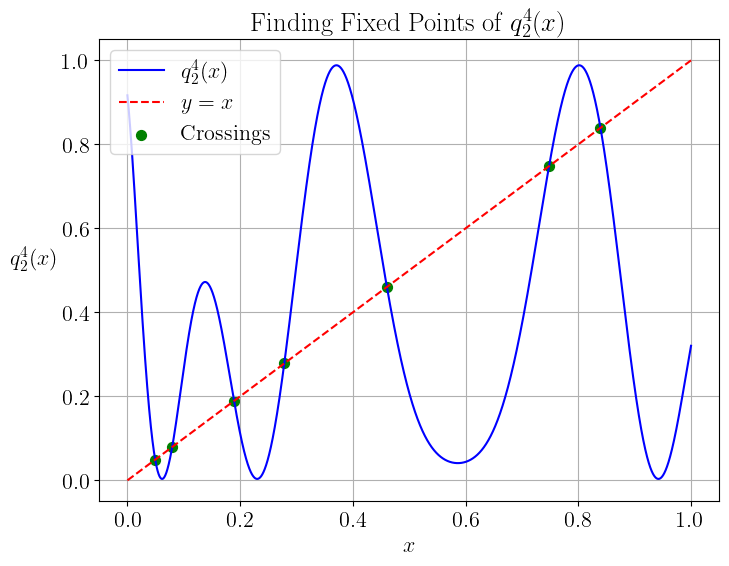

4-period orbit at 0.049 with orbit [0.049, 0.839, 0.189, 0.46] and coding 0100
2-period orbit at 0.079 with orbit [0.079, 0.748, 0.08, 0.748] and coding 0101
4-period orbit at 0.189 with orbit [0.189, 0.46, 0.049, 0.839] and coding 0001
fixed point at 0.278 with orbit [0.278, 0.278, 0.278, 0.278] and coding 0000
4-period orbit at 0.460 with orbit [0.46, 0.049, 0.839, 0.189] and coding 0010
2-period orbit at 0.748 with orbit [0.748, 0.079, 0.748, 0.08] and coding 1010
4-period orbit at 0.839 with orbit [0.839, 0.189, 0.461, 0.049] and coding 1000


In [212]:
def q2(x):
    return 1 - 3.4 * x + 2.9 * x**2

x_e = 3.4 / 5.8

def q2_n(x, n):
    for _ in range(n):
        x = q2(x)
    return x

def get_coding(orbit):
    coding = []
    for x in orbit:
        if 0 <= x < x_e:
            coding.append('0')
        elif x_e <= x < 1:
            coding.append('1')
    return ''.join(coding)

x = np.linspace(0, 1, 10000)
y = q2_n(x, 4)
# count number of croosings of y = x
crossings = np.where(np.diff(np.sign(y - x)))[0]
plt.figure(figsize=(8, 6))
plt.title('Finding Fixed Points of $q_2^4(x)$')
plt.xlabel('$x$')
plt.ylabel('$q_2^4(x)$', rotation=0, labelpad=20)
plt.plot(x, y, label='$q_2^4(x)$', color='blue')
plt.plot(x, x, label='$y = x$', color='red', linestyle='--')
plt.scatter(x[crossings], y[crossings], color='green', label='Crossings', s=50)
plt.legend()
plt.grid()
plt.show()

for crossing in crossings:
    orbit = []
    for n in range(4):
        orbit.append(q2_n(x[crossing], n))
    if np.abs(orbit[0] - orbit[1]) <= 1e-2:
        print(f"fixed point at {x[crossing]:.3f} with orbit {[round(x, 3) for x in orbit]}" + \
              f" and coding {get_coding(orbit)}")
    elif np.abs(orbit[0] - orbit[2]) <= 1e-2:
        print(f"2-period orbit at {x[crossing]:.3f} with orbit {[round(x, 3) for x in orbit]}" + \
              f" and coding {get_coding(orbit)}")
    else:
        print(f"4-period orbit at {x[crossing]:.3f} with orbit {[round(x, 3) for x in orbit]}" + \
              f" and coding {get_coding(orbit)}")
        
    


## Subsection 1.5 - Finding the physical measure $\mu_p[0,0.5]$

In [ ]:
### Subsection 5 - Finding physical measure of $q_2$
def i(x):
    if 0 <= x <= 0.5:
        return 1
    return 0

def q2(x):
    return 1 - 3.4 * x + 2.9 * x**2


x0 = 0.3
x = x0
sum = 0. 
T = 10000
for t in range(T):
    sum += i(x)
    x = q2(x)
physical_measure = sum / T
print(physical_measure)

0.656
